
=== TORNADO ===
Features used: ['precipitation', 'windgusts_10m', 'surface_pressure', 'cloudcover_high', 'soil_temperature_100_to_255cm', 'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm', 'temp_lapse', 'convective_potential', 'gust_spike', 'state', 'county', 'event_latitude', 'event_longitude', 'month']
              precision    recall  f1-score   support

           0       0.77      0.64      0.70      1208
           1       0.75      0.85      0.80      1551

    accuracy                           0.76      2759
   macro avg       0.76      0.74      0.75      2759
weighted avg       0.76      0.76      0.75      2759

ROC-AUC: 0.83


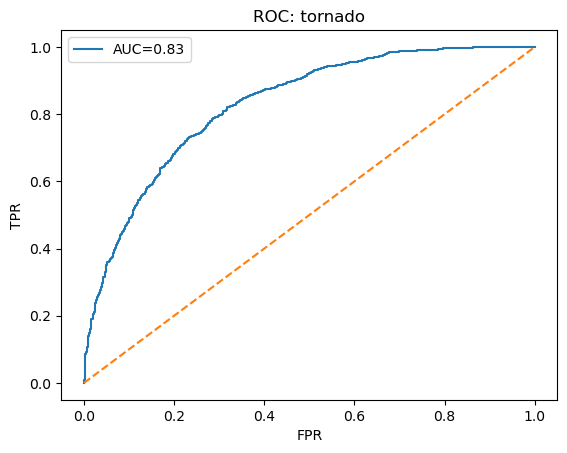


=== THUNDERSTORM ===
Features used: ['dew_point_2m', 'precipitation', 'rain', 'snow_depth', 'windgusts_10m', 'surface_pressure', 'cloudcover_high', 'soil_moisture_28_to_100cm', 'temp_lapse', 'heavy_precip', 'gust_spike', 'state', 'event_latitude', 'event_longitude', 'month']
              precision    recall  f1-score   support

           0       0.78      0.60      0.68     11159
           1       0.81      0.91      0.86     21287

    accuracy                           0.80     32446
   macro avg       0.79      0.75      0.77     32446
weighted avg       0.80      0.80      0.80     32446

ROC-AUC: 0.87


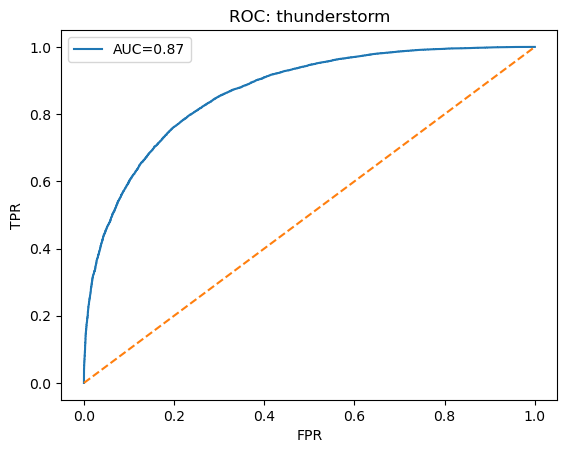


=== HAIL ===
Features used: ['temperature_2m', 'dew_point_2m', 'rain', 'windgusts_10m', 'surface_pressure', 'cloudcover_low', 'cloudcover_high', 'soil_temperature_0_to_7cm', 'precip_spike', 'state', 'county', 'event_latitude', 'event_longitude', 'month', 'hour']
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      9160
           1       0.78      0.88      0.82      8317

    accuracy                           0.82     17477
   macro avg       0.82      0.82      0.82     17477
weighted avg       0.83      0.82      0.82     17477

ROC-AUC: 0.91


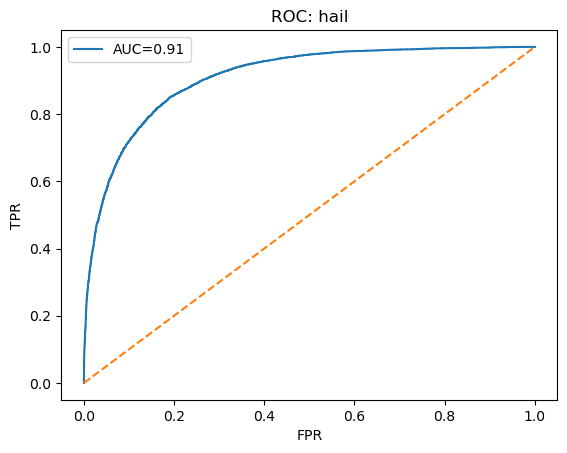


=== HEAVY_SNOW ===
Features used: ['temperature_2m', 'precipitation', 'snow_depth', 'surface_pressure', 'cloudcover_low', 'cloudcover_mid', 'temp_anomaly', 'snow_rate', 'low_visibility', 'state', 'county', 'event_latitude', 'event_longitude', 'month', 'hour']
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2096
           1       0.52      0.49      0.50       315

    accuracy                           0.87      2411
   macro avg       0.72      0.71      0.72      2411
weighted avg       0.87      0.87      0.87      2411

ROC-AUC: 0.88


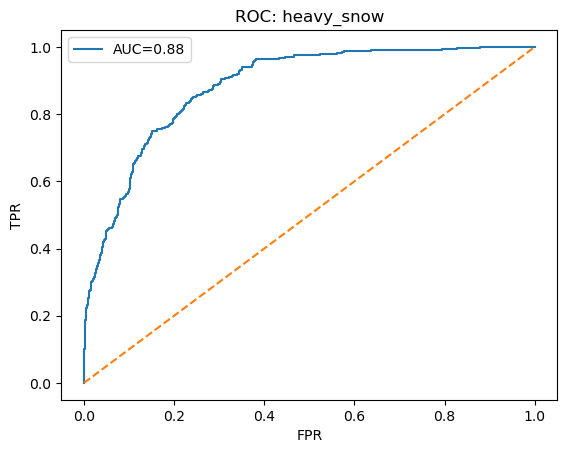


=== HIGH_WIND ===
Features used: ['surface_pressure', 'temperature_2m', 'relative_humidity_2m', 'cloudcover', 'winddirection_10m', 'winddirection_100m', 'wind_shear', 'low_pressure', 'wind_severity', 'state', 'county', 'event_latitude', 'event_longitude', 'month', 'hour']
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3194
           1       0.61      0.76      0.68       489

    accuracy                           0.90      3683
   macro avg       0.79      0.84      0.81      3683
weighted avg       0.92      0.90      0.91      3683

ROC-AUC: 0.95


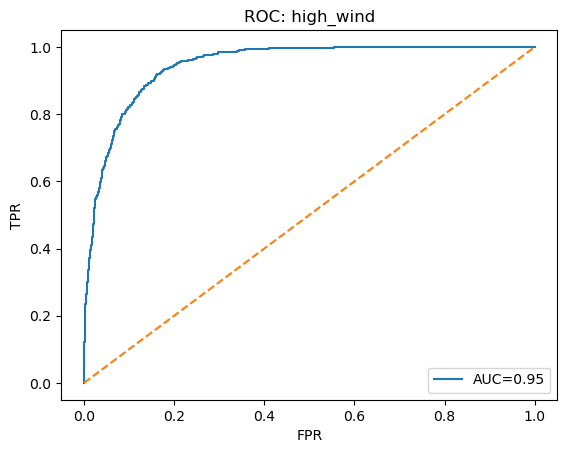


=== COMBINED ===
Combined ROC-AUC: 0.90
              precision    recall  f1-score   support

   no_outage       0.85      0.72      0.78     26817
      outage       0.79      0.89      0.84     31959

    accuracy                           0.82     58776
   macro avg       0.82      0.81      0.81     58776
weighted avg       0.82      0.82      0.81     58776



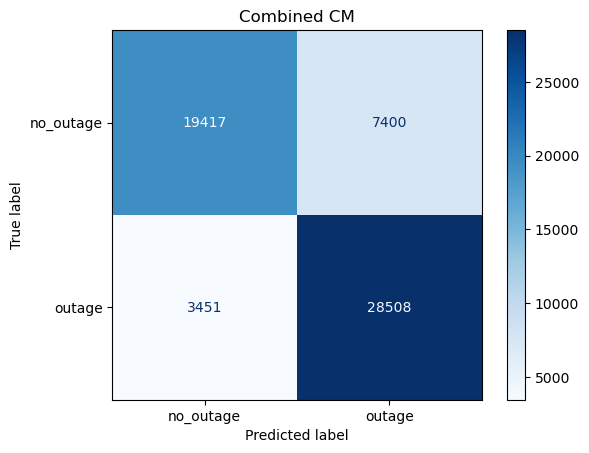


Features per event:
tornado: ['precipitation', 'windgusts_10m', 'surface_pressure', 'cloudcover_high', 'soil_temperature_100_to_255cm', 'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm', 'temp_lapse', 'convective_potential', 'gust_spike', 'state', 'county', 'event_latitude', 'event_longitude', 'month']
thunderstorm: ['dew_point_2m', 'precipitation', 'rain', 'snow_depth', 'windgusts_10m', 'surface_pressure', 'cloudcover_high', 'soil_moisture_28_to_100cm', 'temp_lapse', 'heavy_precip', 'gust_spike', 'state', 'event_latitude', 'event_longitude', 'month']
hail: ['temperature_2m', 'dew_point_2m', 'rain', 'windgusts_10m', 'surface_pressure', 'cloudcover_low', 'cloudcover_high', 'soil_temperature_0_to_7cm', 'precip_spike', 'state', 'county', 'event_latitude', 'event_longitude', 'month', 'hour']
heavy_snow: ['temperature_2m', 'precipitation', 'snow_depth', 'surface_pressure', 'cloudcover_low', 'cloudcover_mid', 'temp_anomaly', 'snow_rate', 'low_visibility', 'state', 'county', 'event_l

In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer,
    f1_score
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# 1. Load & Common Preprocessing
df = pd.read_csv('complete_data.csv')
df['event_datetime'] = pd.to_datetime(df['event_datetime'], format='%d/%m/%y %H:%M')
df['month'] = df['event_datetime'].dt.month
df['hour']  = df['event_datetime'].dt.hour

# Fill missing
num_cols = df.select_dtypes(include=['float64','int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
for col in ['state','county']:
    df[col] = df[col].fillna(df[col].mode()[0])
    df[col] = LabelEncoder().fit_transform(df[col])

df['event_type'] = df['event_type'].str.lower().str.strip()

# Base weather features
weather_features_base = [
    'temperature_2m','dew_point_2m','relative_humidity_2m',
    'precipitation','rain','snowfall','snow_depth',
    'windspeed_10m','windspeed_100m','winddirection_10m','winddirection_100m',
    'windgusts_10m','surface_pressure','cloudcover','cloudcover_low',
    'cloudcover_mid','cloudcover_high',
    'soil_temperature_0_to_7cm','soil_temperature_7_to_28cm',
    'soil_temperature_28_to_100cm','soil_temperature_100_to_255cm',
    'soil_moisture_0_to_7cm','soil_moisture_7_to_28cm',
    'soil_moisture_28_to_100cm','soil_moisture_100_to_255cm'
]

# 2. Feature engineering functions
def fe_tornado(d):
    wf = weather_features_base
    d['wind_shear'] = (d['windspeed_100m'] - d['windspeed_10m']).fillna(0)
    d['wind_direction_shear'] = (d['winddirection_100m'] - d['winddirection_10m']).abs().fillna(0)
    d['temp_lapse'] = (d['temperature_2m'] - d['soil_temperature_0_to_7cm']).fillna(0)
    d['convective_potential'] = (d['temperature_2m'] * d['relative_humidity_2m'] / d['surface_pressure']).fillna(0)
    wp = d['windspeed_10m'] * d['windgusts_10m']
    d['wind_power'] = wp / (wp.std() if wp.std() else 1)
    q_w, q_g = d['windspeed_10m'].quantile(0.75), d['windgusts_10m'].quantile(0.75)
    d['extreme_wind'] = (d['windspeed_10m'] > q_w).astype(int)
    d['gust_spike'] = (d['windgusts_10m'] > q_g).astype(int)
    d['tornado_severity'] = (
        d['windspeed_10m'] + d['windgusts_10m'] + d['wind_shear'] + d['convective_potential']
    ) / 4
    return wf + ['wind_shear','wind_direction_shear','temp_lapse','convective_potential','wind_power','extreme_wind','gust_spike','tornado_severity']

# ... define fe_thunder, fe_hail, fe_snow, fe_wind similarly ...

def fe_thunder(d):
    wf = weather_features_base
    d['wind_shear'] = (d['windspeed_100m'] - d['windspeed_10m']).fillna(0)
    d['temp_lapse'] = (d['temperature_2m'] - d['soil_temperature_0_to_7cm']).fillna(0)
    d['convective_potential'] = (d['temperature_2m'] * d['relative_humidity_2m'] / d['surface_pressure']).fillna(0)
    q_p = d['precipitation'].quantile(0.75)
    d['heavy_precip'] = (d['precipitation'] > q_p).astype(int)
    q_g = d['windgusts_10m'].quantile(0.75)
    d['gust_spike'] = (d['windgusts_10m'] > q_g).astype(int)
    d['thunder_severity'] = (d['convective_potential'] + d['heavy_precip']*d['precipitation'] + d['wind_shear'])/3
    return wf + ['wind_shear','temp_lapse','convective_potential','heavy_precip','gust_spike','thunder_severity']

def fe_hail(d):
    wf = [
        'temperature_2m','dew_point_2m','relative_humidity_2m',
        'precipitation','rain','snowfall','snow_depth',
        'windspeed_10m','windgusts_10m','surface_pressure',
        'cloudcover','cloudcover_low','cloudcover_mid','cloudcover_high',
        'soil_temperature_0_to_7cm','soil_moisture_0_to_7cm'
    ]
    d['dew_depression'] = (d['temperature_2m'] - d['dew_point_2m']).fillna(0)
    d['convective_potential'] = (d['temperature_2m']*d['relative_humidity_2m']/d['surface_pressure']).fillna(0)
    q = d['precipitation'].quantile(0.75)
    d['precip_spike'] = (d['precipitation']>q).astype(int)
    d['gust_shear'] = (d['windgusts_10m'] - d['windspeed_10m']).fillna(0)
    d['hail_severity'] = (d['convective_potential'] + d['precip_spike']*d['precipitation'] + d['dew_depression'] + d['gust_shear'])/4
    return wf + ['dew_depression','convective_potential','precip_spike','gust_shear','hail_severity']

def fe_snow(d):
    wf = [
        'temperature_2m','dew_point_2m','relative_humidity_2m',
        'precipitation','snowfall','snow_depth',
        'windspeed_10m','windgusts_10m','surface_pressure',
        'cloudcover','cloudcover_low','cloudcover_mid','cloudcover_high'
    ]
    d['temp_anomaly'] = (0 - d['temperature_2m']).clip(lower=0).fillna(0)
    d['snow_rate'] = d['snowfall']/(d['precipitation']+1e-3)
    wp = d['windspeed_10m']*d['windgusts_10m']
    d['wind_power'] = wp/(wp.std() if wp.std() else 1)
    d['low_visibility'] = ((d['cloudcover_low']>0.75)&(d['snowfall']>d['snowfall'].quantile(0.75))).astype(int)
    d['snow_severity'] = (d['temp_anomaly'] + d['snowfall'] + d['wind_power'] + d['low_visibility'])/4
    return wf + ['temp_anomaly','snow_rate','wind_power','low_visibility','snow_severity']

def fe_wind(d):
    wf = ['windspeed_10m','windspeed_100m','windgusts_10m','surface_pressure','temperature_2m','relative_humidity_2m','cloudcover','winddirection_10m','winddirection_100m']
    d['wind_shear'] = (d['windspeed_100m'] - d['windspeed_10m']).fillna(0)
    d['dir_shear']  = (d['winddirection_100m'] - d['winddirection_10m']).abs().fillna(0)
    d['gust_ratio']= d['windgusts_10m']/(d['windspeed_10m']+1e-3)
    lowp = d['surface_pressure'].quantile(0.25)
    d['low_pressure'] = (d['surface_pressure']<lowp).astype(int)
    d['wind_severity'] = (d['wind_shear'] + d['gust_ratio']*d['windgusts_10m'] + d['dir_shear'] + d['low_pressure'])/4
    return wf + ['wind_shear','dir_shear','gust_ratio','low_pressure','wind_severity']

engineers = {'tornado': fe_tornado, 'thunderstorm': fe_thunder, 'hail': fe_hail, 'heavy_snow': fe_snow, 'high_wind': fe_wind}

# 3. Train & evaluate each event, aggregate results
all_y_true, all_y_pred, all_y_prob = [], [], []
models, scalers, feats_used = {}, {}, {}

for evt, fe_func in engineers.items():
    d_evt = df[df['event_type']==evt].copy()
    if len(d_evt) < 10:
        print(f"→ skipping {evt}, only {len(d_evt)} samples")
        continue

    feat_list = fe_func(d_evt) + ['state','county','event_latitude','event_longitude','month','hour']
    feat_list = [f for f in feat_list if f in d_evt]
    d_evt[feat_list] = d_evt[feat_list].fillna(d_evt[feat_list].mean())

    X, y = d_evt[feat_list], d_evt['caused_power_outage']
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    try:
        X_tr, y_tr = SMOTE(sampling_strategy=0.5, random_state=42).fit_resample(X_tr, y_tr)
    except ValueError:
        X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_tr, y_tr)

    scaler = StandardScaler().fit(X_tr)
    X_tr_scaled = pd.DataFrame(scaler.transform(X_tr), columns=feat_list)
    X_te_scaled = pd.DataFrame(scaler.transform(X_te), columns=feat_list)

    clf = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    clf.set_params(scale_pos_weight=len(y_tr[y_tr==0]) / len(y_tr[y_tr==1]))
    selector = RFE(clf, n_features_to_select=15, step=1).fit(X_tr_scaled, y_tr)
    sel = list(X_tr_scaled.columns[selector.support_])

    X_tr_sel, X_te_sel = X_tr_scaled[sel], X_te_scaled[sel]
    param_dist = {
        'n_estimators': np.arange(100,600,50),
        'max_depth': [3,5,7,10,15],
        'learning_rate': [0.01,0.05,0.1,0.2,0.3],
        'subsample': [0.6,0.7,0.8,0.9,1.0],
        'colsample_bytree': [0.6,0.7,0.8,0.9,1.0],
        'min_child_weight': [1,3,5,7],
        'gamma':[0,0.1,0.2,0.3,0.4]
    }
    search = RandomizedSearchCV(clf, param_dist, n_iter=30,
                                scoring=make_scorer(f1_score), cv=5,
                                n_jobs=-1, random_state=42).fit(X_tr_sel, y_tr)
    best = search.best_estimator_

    y_prob = best.predict_proba(X_te_sel)[:,1]
    y_pred = (y_prob >= 0.4).astype(int)

    # store
    models[evt], scalers[evt], feats_used[evt] = best, scaler, sel
    all_y_true.extend(y_te)
    all_y_pred.extend(y_pred)
    all_y_prob.extend(y_prob.tolist())

    # per-event eval
    auc = roc_auc_score(y_te, y_prob)
    print(f"\n=== {evt.upper()} ===")
    print("Features used:", sel)
    print(classification_report(y_te, y_pred))
    print(f"ROC-AUC: {auc:.2f}")
    fpr,tpr,_ = roc_curve(y_te, y_prob)
    plt.figure(); plt.plot(fpr,tpr,label=f'AUC={auc:.2f}'); plt.plot([0,1],[0,1],'--');
    plt.title(f'ROC: {evt}'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

# 4. Combined evaluation
combined_auc = roc_auc_score(all_y_true, all_y_prob)
print(f"\n=== COMBINED ===\nCombined ROC-AUC: {combined_auc:.2f}")
print(classification_report(all_y_true, all_y_pred, target_names=['no_outage','outage']))
cm = confusion_matrix(all_y_true, all_y_pred)
Disp=ConfusionMatrixDisplay(cm, display_labels=['no_outage','outage'])
Disp.plot(cmap='Blues'); plt.title('Combined CM'); plt.show()

# 5. Save models and list features
for evt in models:
    joblib.dump(models[evt], f'xgb_{evt}.pkl')
    joblib.dump(scalers[evt], f'scaler_{evt}.pkl')
print("\nFeatures per event:")
for evt, fl in feats_used.items(): print(f"{evt}: {fl}")
